In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

In [2]:
629145480/150/1000

4194.3032

In [1]:
# %%time
df = pd.read_csv('data/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

NameError: name 'pd' is not defined

In [111]:
print(df.shape)
df.head()

(629145480, 2)


,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [112]:
import torch
from torch.utils.data import Dataset, DataLoader
# import cv2
import torch.nn as nn
import torch.nn.functional as F
# from torchvision import transformsclass 
import torch.optim as optim

In [113]:
class RnnBasedLAN(nn.Module):
    def __init__(self, D_in, H, layers=3, dropout=0.2, bidirectional=False):
        super(RnnBasedLAN, self).__init__()
        self.rnn = torch.nn.LSTM(
            D_in,
            H,
            num_layers=layers,
            batch_first=True,
            dropout=dropout,
#             bidirectional=False,
        )
        self.norm = nn.LayerNorm(H)
        self.conv = nn.Conv2d(H, 1, 1)
        
    def forward(self, x):
        """x.shape = (batch_size, seq_len, features)"""
        x, (h_n, c_n) = self.rnn(x)
        x = self.norm(x)
        x = x.transpose(1,2)
        return self.conv(x[:,:,:,None]).squeeze()
    
def test_rnn():
    x = torch.rand(32,150,12)
    mdl = RnnBasedLAN(12,16)
    print(mdl(x).shape)
test_rnn()

torch.Size([32, 150])


In [114]:
def extract_features(z):
#     print(z.shape)
    array = [z.mean(axis=1), 
                  z.min(axis=1),
                  z.max(axis=1),
                  z.std(axis=1),
#                  z.median(axis=1),
                    z.sum(axis=1),
                 [len(z[i,np.abs(z[i,:]) > 500]) for i in range(z.shape[0])],
                 z.max(axis=1) - np.abs(z.min(axis=1)),
                  np.quantile(z, 0.05,axis=1),
            ]
#     print([np.array(i).shape for i in array])
    return np.c_[array].T.astype(np.float32)

extract_features(np.random.rand(150,100))
# For a given ending position "last_index", we split the last 150'000 values 
# of "x" into 150 pieces of length 1000 each. So n_steps * step_length should equal 150'000.
# From each piece, a set features are extracted. This results in a feature matrix 
# of dimension (150 time steps x features).  
def create_X(x, last_index=None, n_steps=150, step_length=1000):
    if last_index == None:
        last_index=len(x)
       
    assert last_index - n_steps * step_length >= 0

    # Reshaping and approximate standardization with mean 5 and std 3.
    temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1) - 5 ) / 3
#     print(temp.shape,extract_features(temp).shape)
    # Extracts features of sequences of full length 1000, of the last 100 values and finally also 
    # of the last 10 observations. 
    return np.c_[extract_features(temp),
                 extract_features(temp[:, -step_length // 10:]),
                 extract_features(temp[:, -step_length // 100:])].astype(np.float32)

# Query "create_X" to figure out the number of features
n_features = create_X(df.to_numpy(), n_steps=10).shape[1]
print("Our RNN is based on %i features"% n_features)

Our RNN is based on 24 features


In [135]:

class LAN_Dataset(Dataset):
    def __init__(
        self,
        df,
        seq_len=150,
        rand=False
#         overlap
    ):
        self.x =  df.loc[:,'acoustic_data'].to_numpy()
        self.y = df.loc[:,'time_to_failure'].to_numpy()
        self.seq_len = seq_len
        self.rand = rand
        
    def __len__(self):
        return int(self.x.shape[0]/1000/self.seq_len)-1
        

    def __getitem__(self, idx):
        idx +=1
        idx *= 150*1000
        if self.rand:
            idx += int(np.random.randn()*999)
#         print(idx)
        sample = {
            "x": create_X(self.x, last_index=idx, n_steps=self.seq_len, step_length=1000),
            "y": self.y[np.arange(idx - self.seq_len*1000,idx,1000)],
        }
        

        return sample['x'],sample['y'].astype(np.float32)
    
ds = LAN_Dataset(df)
for i in tqdm(range(len(ds))):
    dct = [o.shape for o in ds[i]]
#     break
print(dct)



100%|██████████| 4193/4193 [00:25<00:00, 162.35it/s]

[(150, 24), (150,)]


In [136]:
idx = 150*1000*64
print(idx- 150*1000,idx)
np.arange(idx - 150*1000,idx,1000).shape

9450000 9600000


(150,)

[1.469098 1.469097 1.469096 1.4681   ... 1.431895 1.430799 1.430798 1.430797]


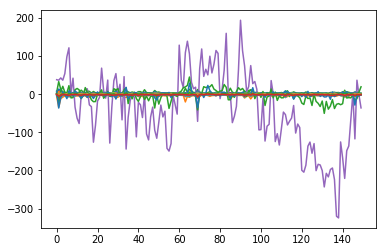

11.455598


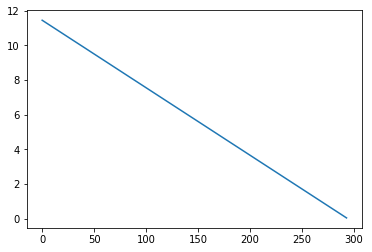

In [138]:
import matplotlib.pyplot as plt
def plot_sample(sample):    
    plt.plot(sample[0])
    print(sample[1])
    plt.show()
plot_sample(ds[0])
second_earthquake = 50085877
valid_ds = LAN_Dataset(df.iloc[second_earthquake-150*1000*295:second_earthquake,:])
result = []
for i in range(len(valid_ds)):
    result.append(valid_ds[i][1][-1])
print(result[0])
plt.figure()
plt.plot(result)

In [139]:
# from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
# between train and validation
second_earthquake = 50085877

train_dl = DataLoader(LAN_Dataset(df.iloc[:-150*1000*65,:],rand = True), batch_size= 64, num_workers=4)
valid_dl = DataLoader(LAN_Dataset(df.iloc[second_earthquake-150*1000*295:second_earthquake,:]), batch_size= 32, num_workers=2)

# optimizer = torch.optim.Adam(model.parameters())
loss = torch.nn.MSELoss()


In [140]:
def last_step_acc(preds, targs):
    return torch.mean(torch.abs( preds[:,-1]-targs[:,-1]))


In [141]:
from fastai.basic_data import *
from fastai.basic_train import Learner
from fastai.train import fit_one_cycle

In [142]:
data_bunch = DataBunch(train_dl, valid_dl)

In [143]:
learn = Learner(data_bunch, RnnBasedLAN(24,32), loss_func=loss, metrics = [last_step_acc])

In [144]:
learn.fit_one_cycle(10,0.01)

epoch,train_loss,valid_loss,last_step_acc,time
0,19.247458,12.203057,2.968903,00:08
1,14.835608,10.959506,2.865451,00:08
2,13.984459,10.959097,2.865382,00:08
3,13.739780,10.971944,2.866275,00:08
4,13.563043,10.999975,2.868548,00:08
5,13.380735,11.033426,2.871226,00:08
6,13.212665,11.022073,2.870219,00:08
7,13.084837,10.972606,2.866025,00:08
8,12.991527,10.955158,2.864300,00:08
9,12.942304,10.951599,2.863894,00:08


In [145]:
learn.validate()

[10.951599, tensor(2.8639)]

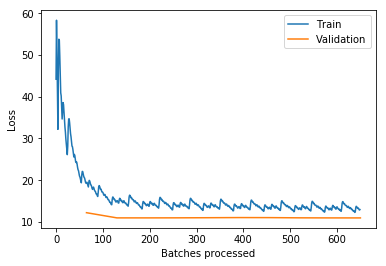

In [146]:
learn.recorder.plot_losses()

In [126]:
mdl = learn.model

In [127]:
# Load submission file
submission = pd.read_csv('data/sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

# Load each test data, create the feature matrix, get numeric prediction
for i, seg_id in enumerate(tqdm(submission.index)):
#     print(i)
    seg = pd.read_csv('data/test/' + seg_id + '.csv')
    x = seg['acoustic_data'].values
    x = torch.tensor(create_X(x))[None,:,:].to(torch.device('cuda'))#.view(1,-1,:)
    pred = mdl(x).cpu().detach().numpy()[0]
    submission.time_to_failure[i] = pred
#     break

submission.head()

# # Save

# 

100%|██████████| 2624/2624 [00:59<00:00, 44.34it/s]


,time_to_failure
seg_id,
seg_00030f,5.424631
seg_0012b5,5.698467
seg_00184e,5.698063
seg_003339,5.692963
seg_0042cc,5.623507


In [128]:
submission.to_csv('submission.csv')